### Generación sCMB con función gaussiana (momeni 2020)

In [12]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import rotate, shift
from skimage.transform import downscale_local_mean

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021"
DIR_NO_CMB = os.path.join(BASE_DIR, "NoCMB")
OUTPUT_DIR = os.path.join(BASE_DIR, "sCMBS_Replica_Momeni")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

FILE_NAME = "101_T1_MRI_SWI_BFC_50mm_HM.nii.gz"
img_path = os.path.join(DIR_NO_CMB, FILE_NAME)

# Coordenadas (Base 1 -> Base 0)
RAW_COORDINATES = [
    (93, 167, 22), (30, 164, 45), (56, 187, 33), (46, 71, 39), (49, 184, 36),
    (52, 109, 16), (84, 161, 28), (96, 184, 65), (27, 154, 43), (132, 97, 19)
]
COORDINATES_LIST = [(x-1, y-1, z-1) for (x, y, z) in RAW_COORDINATES]

# ==========================================
# 2. MOTOR MATEMÁTICO MOMENI (Paper Eq 1-5)
# ==========================================
def generate_momeni_gaussian(target_volume_mm3, voxel_size_mm, oversample=10):
    """
    Genera la Gaussiana 3D siguiendo las ecuaciones exactas del paper.
    target_volume_mm3: Volumen deseado en mm^3 (0.8 - 20)
    voxel_size_mm: Tupla con el tamaño del pixel (ej: 0.5, 0.5, 2.0)
    """
    
    # Constante del paper para FWHM (Full Width Half Max)
    # Ecuación (2): V = 4/3 * pi * (1.175 * sigma)^3
    # K = 1.175 es la relación entre sigma y el radio a media altura
    K = 1.175 
    
    # 1. Calcular Sigma Objetivo (Isotrópica) - Ecuación (2) despejada
    # sigma_t = (V / (4/3 * pi * K^3))^(1/3)
    # Nota: El paper pone 3/4*pi... en la fórmula impresa, pero despejando el volumen de esfera es esto:
    term = (3 * target_volume_mm3) / (4 * np.pi * (K**3))
    sigma_t_mm = np.cbrt(term)
    
    # 2. Aleatorizar formas (Sphericalness) - Ecuaciones (3) y (4)
    # "Best parameters obtained with rmin=0.5 and rmax=0.9"
    rmin, rmax = 0.5, 0.9
    
    rand_x = np.random.uniform(0, 1)
    rand_y = np.random.uniform(0, 1)
    
    sigma_x_mm = sigma_t_mm * ((rmax - rmin) * rand_x + rmin)
    sigma_y_mm = sigma_t_mm * ((rmax - rmin) * rand_y + rmin)
    
    # 3. Calcular Sigma Z para conservar volumen - Ecuación (5)
    # sigma_z = V / (4/3 * pi * K^3 * sigma_x * sigma_y)
    # Simplificando con sigma_t: sigma_z = (sigma_t^3) / (sigma_x * sigma_y)
    sigma_z_mm = (sigma_t_mm**3) / (sigma_x_mm * sigma_y_mm)
    
    # 4. Convertir Sigmas de mm a Píxeles (High Res)
    # High Res pixel size = Original pixel size / oversample
    hr_vx_size = np.array(voxel_size_mm) / oversample
    
    sx_px = sigma_x_mm / hr_vx_size[0]
    sy_px = sigma_y_mm / hr_vx_size[1]
    sz_px = sigma_z_mm / hr_vx_size[2]
    
    # 5. Crear Grid Alta Resolución
    # Tamaño suficiente (ej. 4 veces la sigma mayor para que quepa bien)
    max_sigma = max(sx_px, sy_px, sz_px)
    grid_size = int(max_sigma * 6) + 1 # +1 para asegurar centro impar
    if grid_size % 2 == 0: grid_size += 1
    
    cx, cy, cz = grid_size // 2, grid_size // 2, grid_size // 2
    
    # Desplazamiento aleatorio Sub-voxel (+/- 5 pixeles en High Res)
    # "Randomly located within +/- 5 pixels from the middle of the patch in high res"
    off_x = np.random.uniform(-5, 5)
    off_y = np.random.uniform(-5, 5)
    off_z = np.random.uniform(-5, 5)
    
    x = np.arange(grid_size) - cx - off_x
    y = np.arange(grid_size) - cy - off_y
    z = np.arange(grid_size) - cz - off_z
    
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    
    # Ecuación (1): G(x,y,z)
    # A = 1.0 (Amplitude, la controlaremos luego con Strength)
    exponent = - ( (xx**2)/(2*sx_px**2) + (yy**2)/(2*sy_px**2) + (zz**2)/(2*sz_px**2) )
    gaussian = np.exp(exponent)
    
    # 6. Rotación Aleatoria (Optimized ~30 degrees)
    # Rotamos sobre ejes aleatorios
    angle_x = np.random.uniform(-30, 30)
    angle_y = np.random.uniform(-30, 30)
    angle_z = np.random.uniform(-30, 30)
    
    # Rotamos la matriz 3D
    # order=1 (lineal) para velocidad, o 3 (cubic) para calidad
    img_rot = rotate(gaussian, angle_x, axes=(0,1), reshape=False, order=1)
    img_rot = rotate(img_rot, angle_y, axes=(1,2), reshape=False, order=1)
    img_rot = rotate(img_rot, angle_z, axes=(0,2), reshape=False, order=1)
    
    # 7. Downsampling
    # Usamos medias locales para el efecto de volumen parcial
    low_res_blob = downscale_local_mean(img_rot, (oversample, oversample, oversample))
    
    # Normalizamos para que el pico máximo siga siendo 1.0 tras el downsample/rotación
    if low_res_blob.max() > 0:
        low_res_blob /= low_res_blob.max()
        
    return low_res_blob

def implant_cmb_momeni_math(image_data, center, volume_mm3, voxel_dims, strength=0.9):
    x, y, z = center
    
    # Generar el blob usando la lógica física
    lesion_pattern = generate_momeni_gaussian(volume_mm3, voxel_dims, oversample=10)
    
    # Centrar e Inyectar
    p_shape = lesion_pattern.shape
    dx, dy, dz = p_shape[0]//2, p_shape[1]//2, p_shape[2]//2
    
    x_s, x_e = x - dx, x - dx + p_shape[0]
    y_s, y_e = y - dy, y - dy + p_shape[1]
    z_s, z_e = z - dz, z - dz + p_shape[2]
    
    # Check bounds
    if x_s < 0 or x_e > image_data.shape[0] or \
       y_s < 0 or y_e > image_data.shape[1] or \
       z_s < 0 or z_e > image_data.shape[2]:
        print(f"⚠️ SKIPPING {center}: Borde.")
        return image_data
    
    roi = image_data[x_s:x_e, y_s:y_e, z_s:z_e]
    
    # Ajuste dimensiones
    if roi.shape != lesion_pattern.shape:
        lesion_pattern = lesion_pattern[:roi.shape[0], :roi.shape[1], :roi.shape[2]]

    # Fusión
    mask_multiplier = 1 - (lesion_pattern * strength)
    roi_synth = roi * mask_multiplier
    
    synth_img = image_data.copy()
    synth_img[x_s:x_e, y_s:y_e, z_s:z_e] = roi_synth
    return synth_img

# ==========================================
# 3. EJECUCIÓN 
# ==========================================
print(f"Cargando original...")
nii_orig = nib.load(img_path)
data_orig = nii_orig.get_fdata()

# EXTRAER TAMAÑO DEL VÓXEL (CRÍTICO PARA MOMENI)
voxel_dims = nii_orig.header.get_zooms() # Ej: (0.5, 0.5, 2.0)
print(f"Resolución detectada: {voxel_dims} mm")

data_replica = data_orig.copy()

print(f"Inyectando 10 lesiones (Método Físico Momeni)...")
print("-" * 60)
print(f"{'#':<3} | {'Volumen (mm3)':<15} | {'Strength':<10}")
print("-" * 60)

# Semilla para reproducibilidad (opcional)
np.random.seed(42)

for i, coord in enumerate(COORDINATES_LIST):
    # ALEATORIZACIÓN SEGÚN EL PAPER
    # "Volumes are varied from 0.8 to 20 mm3"
    # OJO: 20 mm3 es ENORME. Para microbleeds típicos, la mayoría son pequeños.
    # Vamos a usar una distribución que favorezca los pequeños pero permita grandes.
    # O simplemente uniforme como dice el texto "varied from...".
    
    vol_random = np.random.uniform(0.8, 10.0) # Pongo tope 10 para no destruir el cerebro, puedes subir a 20.
    
    # Strength: Dejamos el rango que validamos antes (0.85 - 1.0)
    str_random = np.random.uniform(0.85, 1.0)
    
    data_replica = implant_cmb_momeni_math(data_replica, coord, 
                                           volume_mm3=vol_random, 
                                           voxel_dims=voxel_dims, 
                                           strength=str_random)
    
    print(f"{i+1:<3} | {vol_random:<15.4f} | {str_random:<10.4f}")

print("-" * 60)
OUT_FILE_NAME = "101_Replica_Momeni_Math_V1.nii.gz"
out_path = os.path.join(OUTPUT_DIR, OUT_FILE_NAME)

nib.save(nib.Nifti1Image(data_replica, nii_orig.affine, nii_orig.header), out_path)
print(f"Guardado en:\n{out_path}")

Cargando original...
Resolución detectada: (np.float32(0.9375), np.float32(0.93750006), np.float32(1.7499982)) mm
Inyectando 10 lesiones (Método Físico Momeni)...
------------------------------------------------------------
#   | Volumen (mm3)   | Strength  
------------------------------------------------------------
1   | 4.2458          | 0.9926    
2   | 0.9894          | 0.9955    
3   | 6.4290          | 0.8709    
4   | 6.3894          | 0.8756    
5   | 1.9228          | 0.9243    
6   | 9.7202          | 0.9663    
7   | 4.3758          | 0.8907    
8   | 7.9047          | 0.8798    
9   | 8.7406          | 0.9435    
10  | 1.9003          | 0.9570    
------------------------------------------------------------
Guardado en:
/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021/sCMBS_Replica_Momeni/101_Replica_Momeni_Math_V1.nii.gz


### Visualización sCMB y comparativa

Cargando volúmenes...
Generando comparativas...


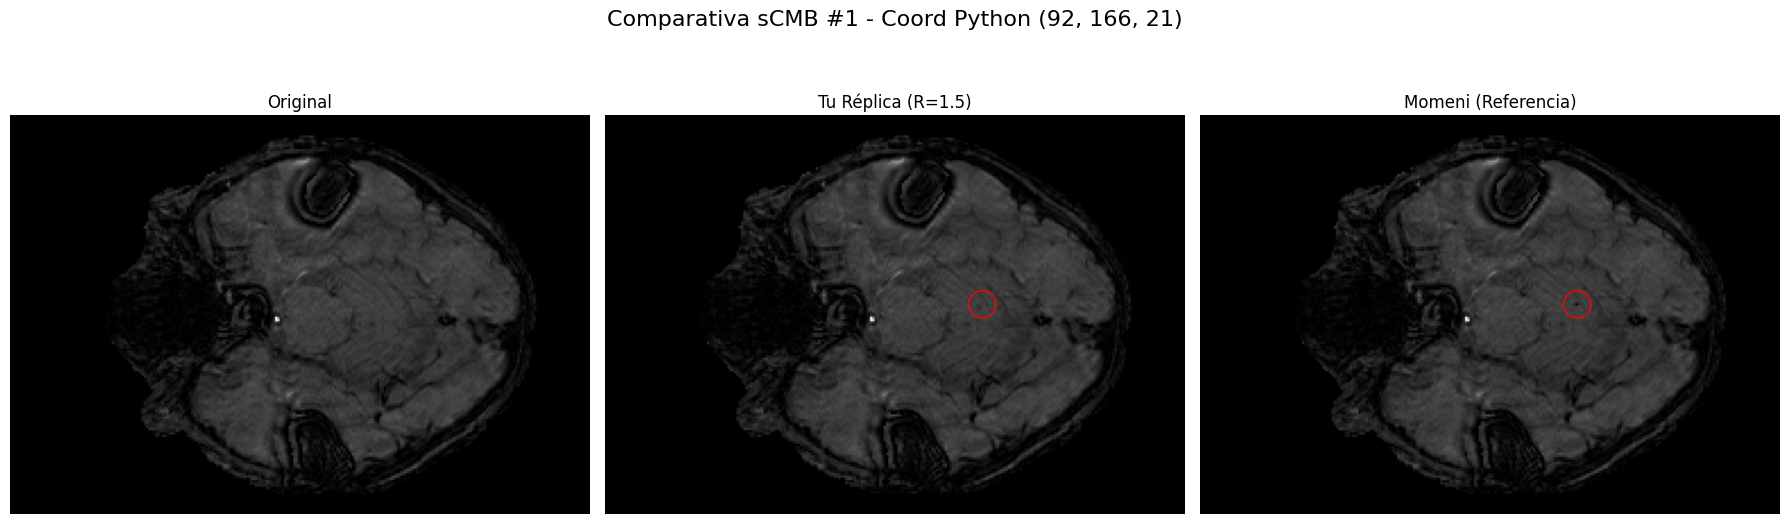

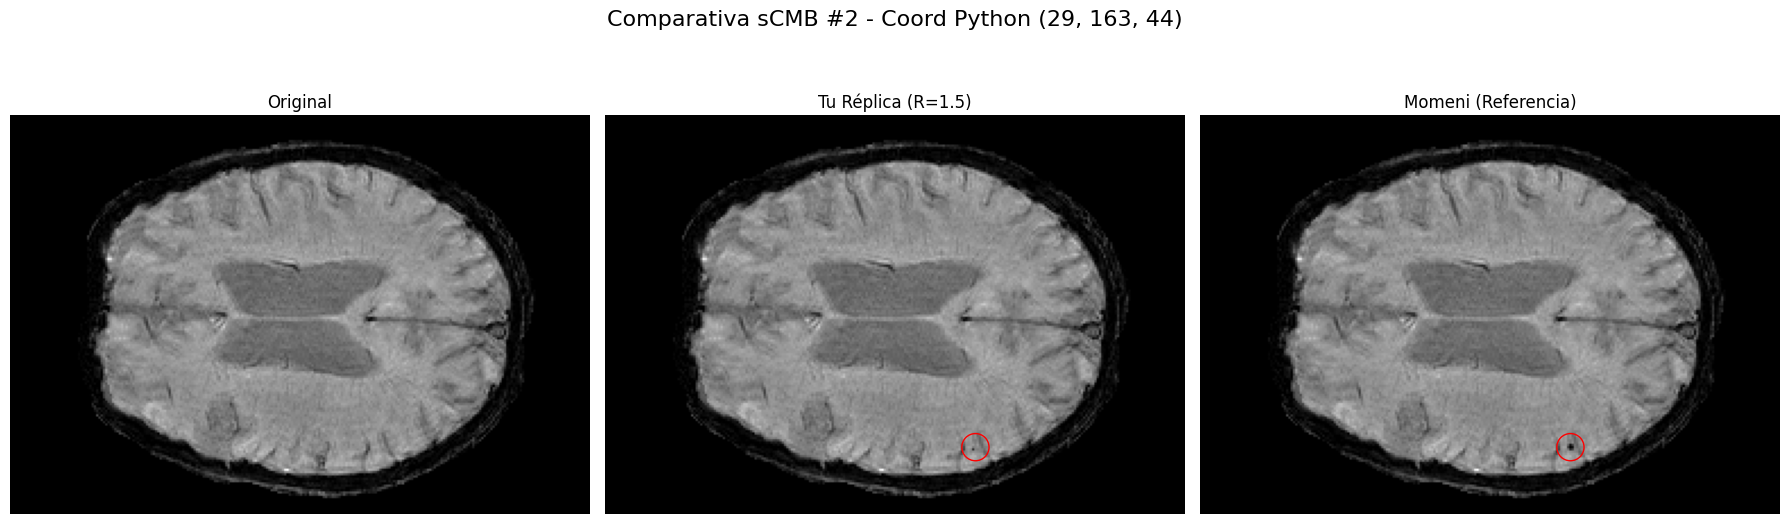

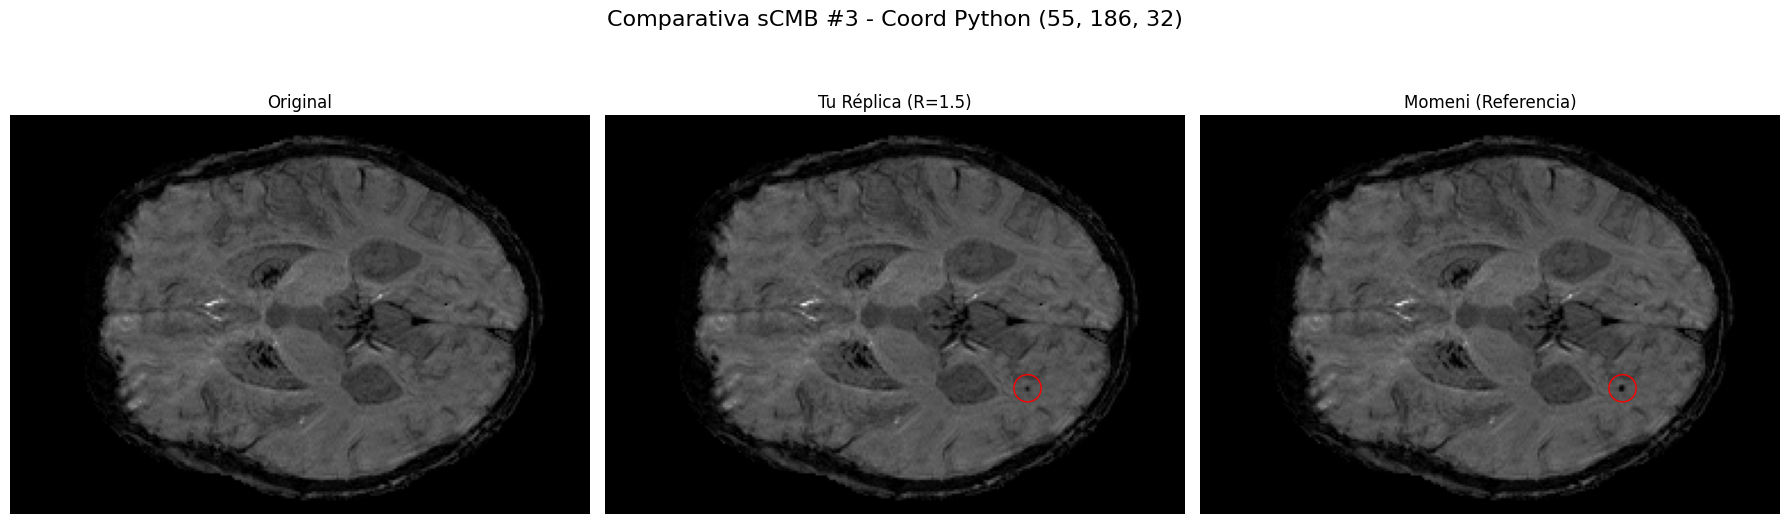

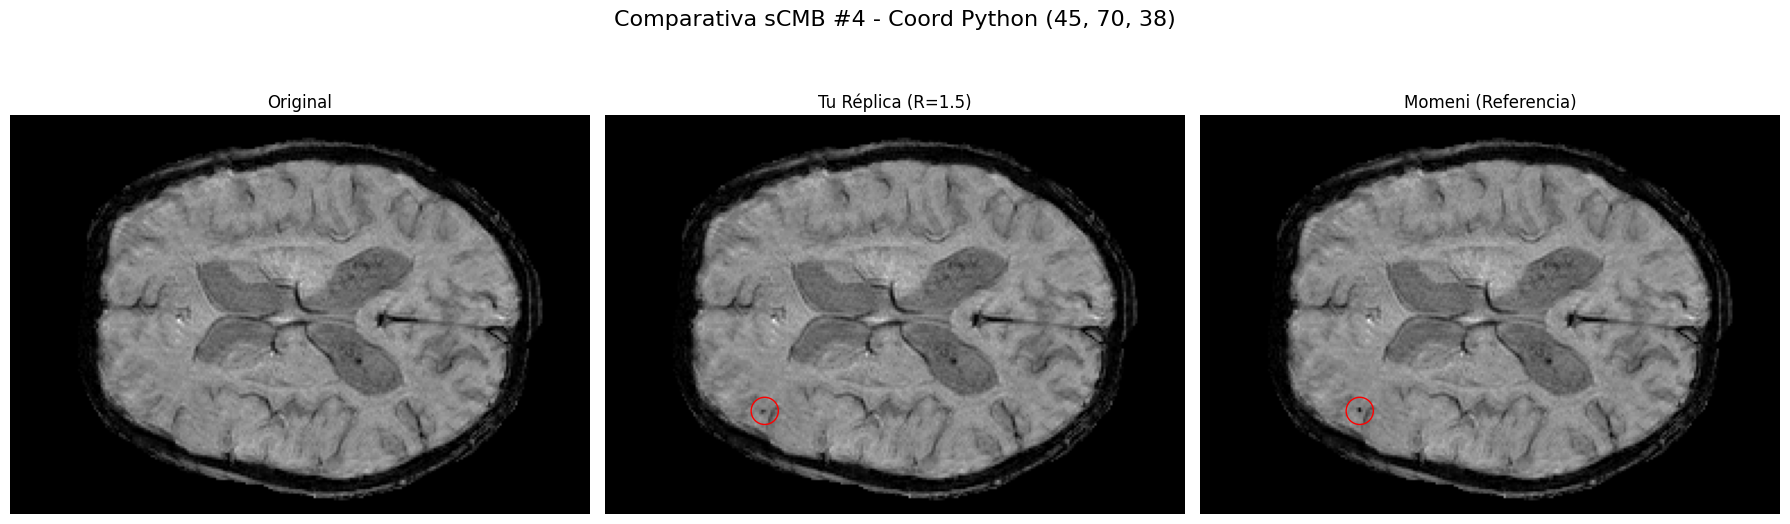

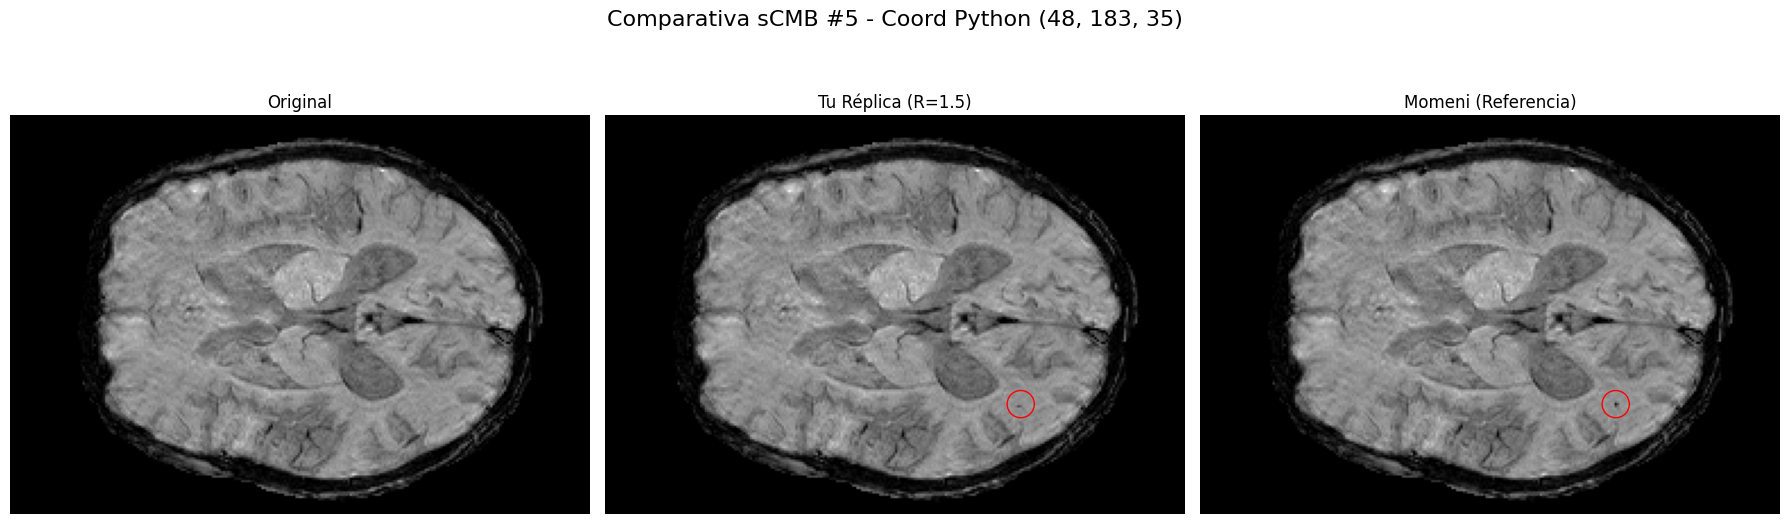

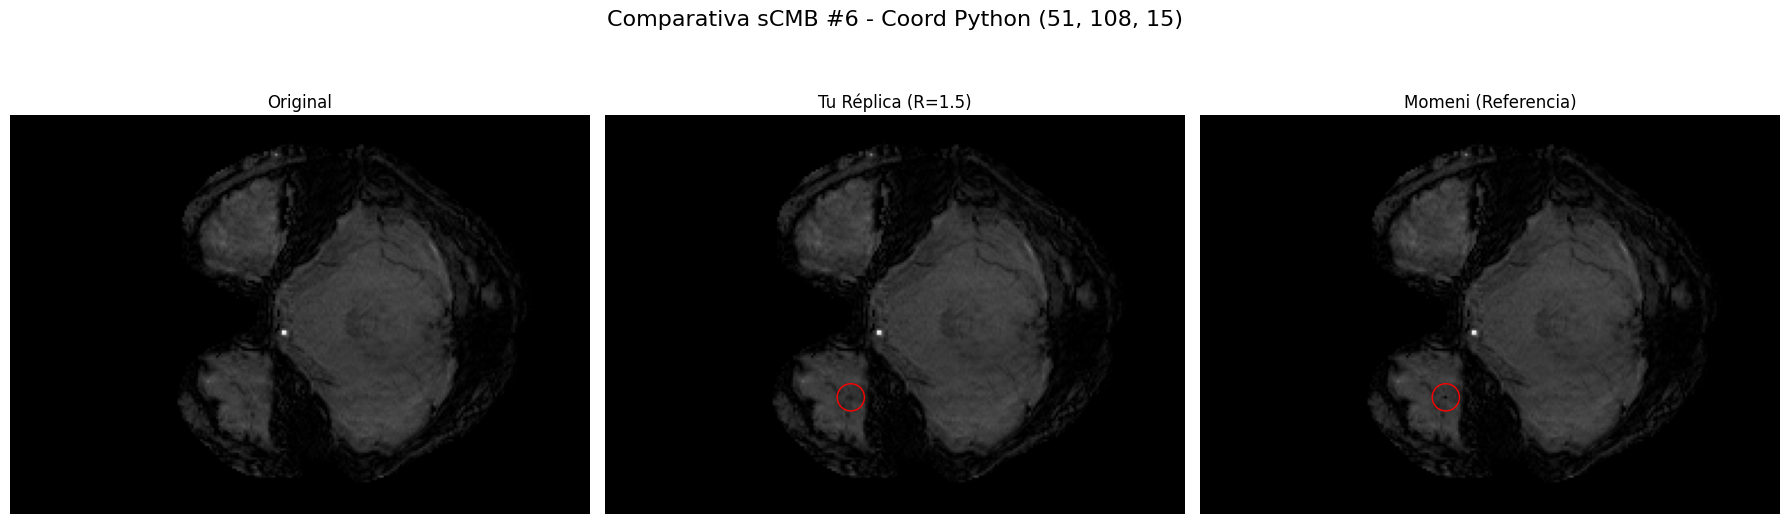

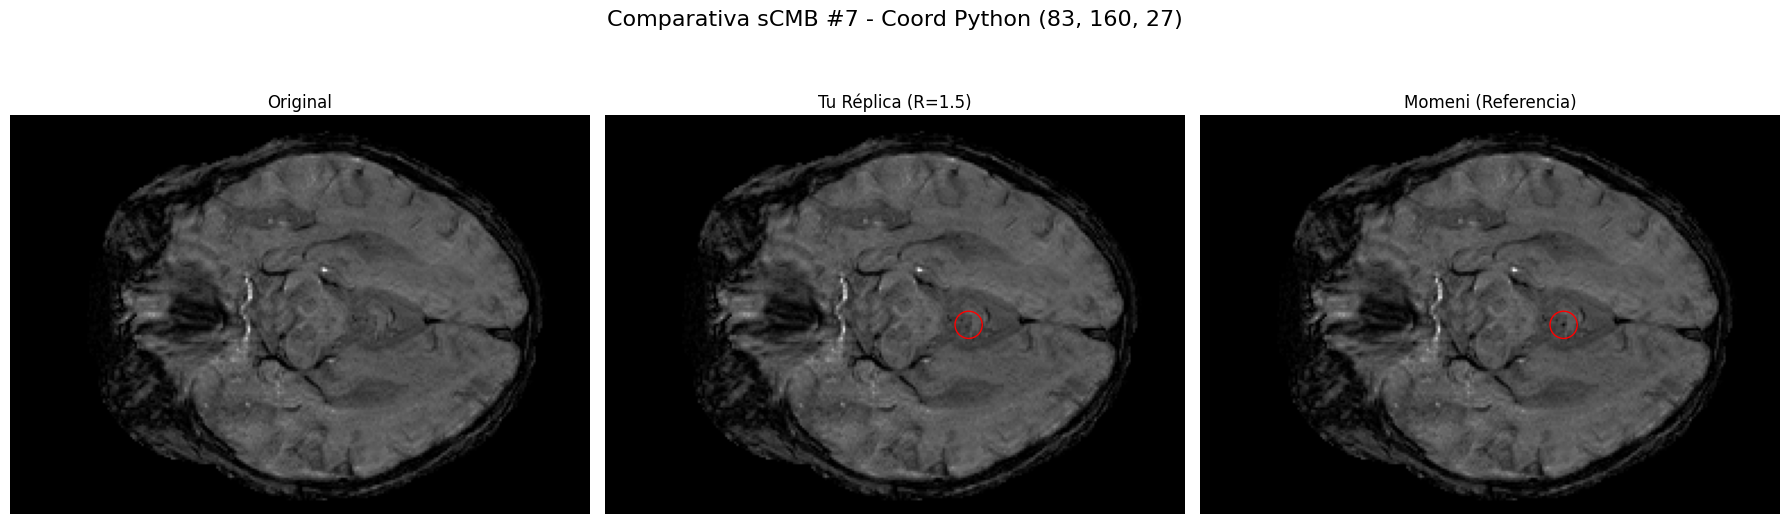

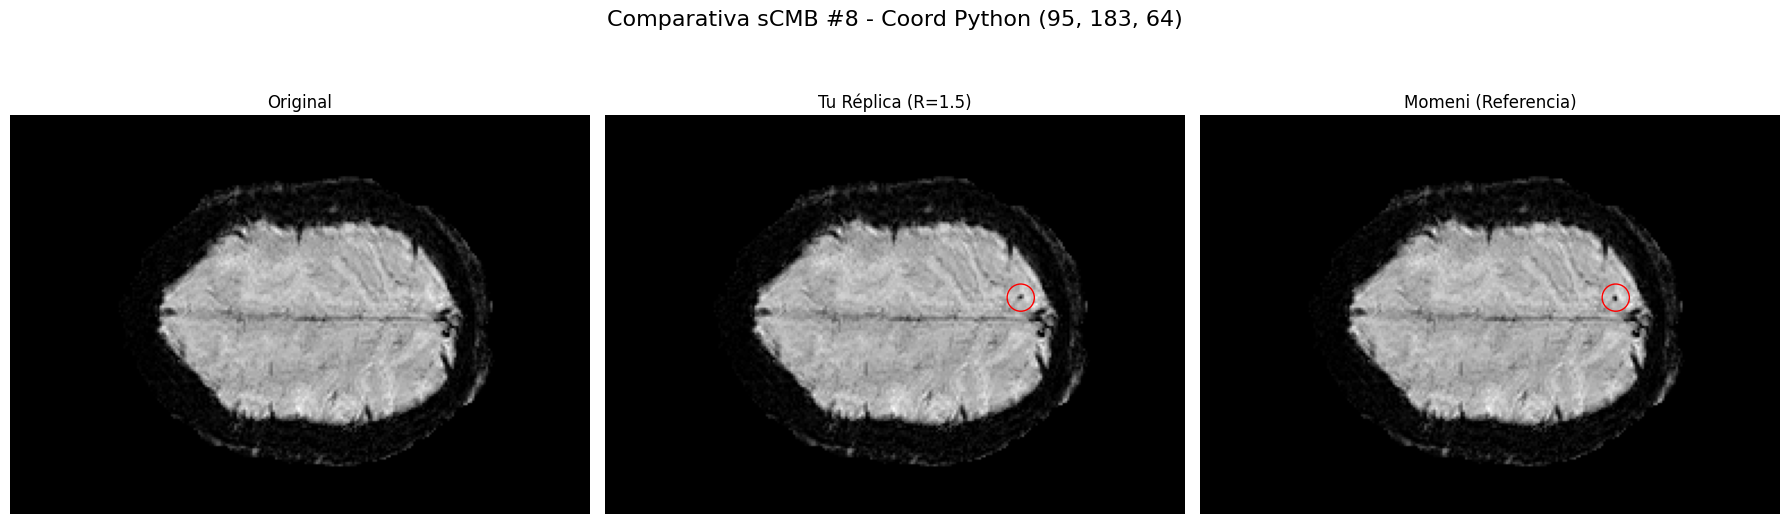

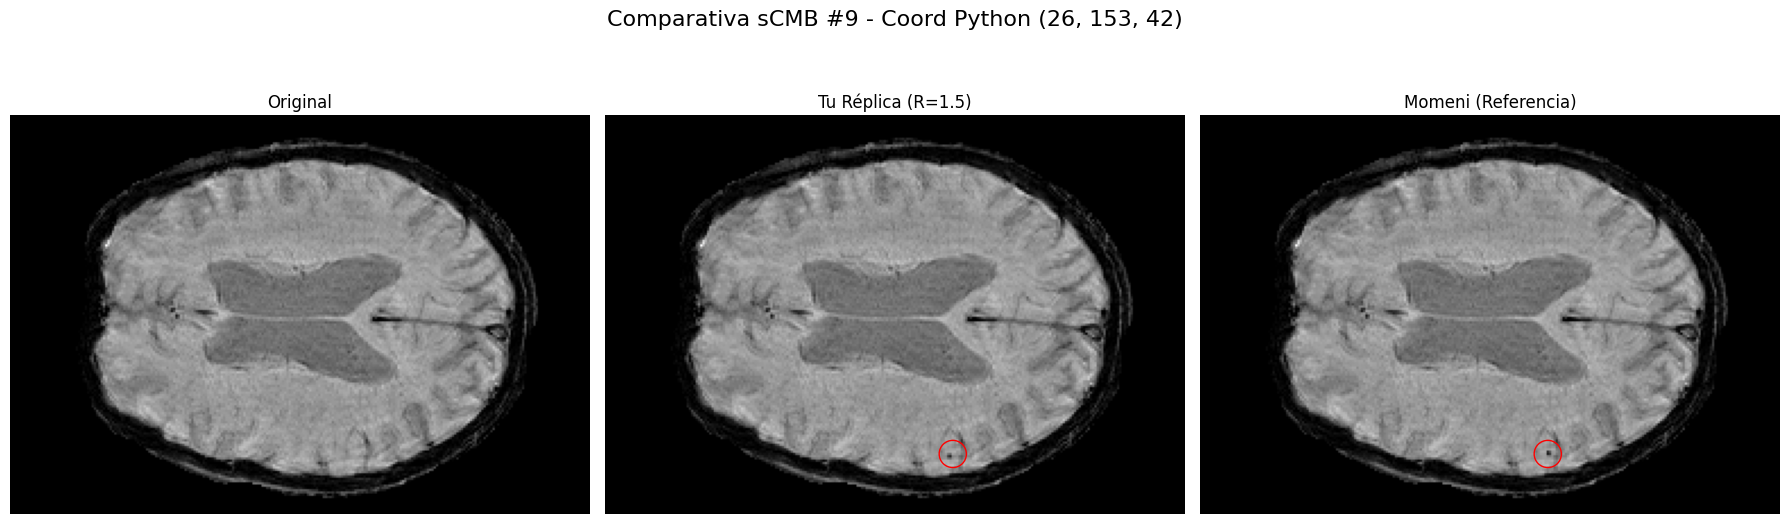

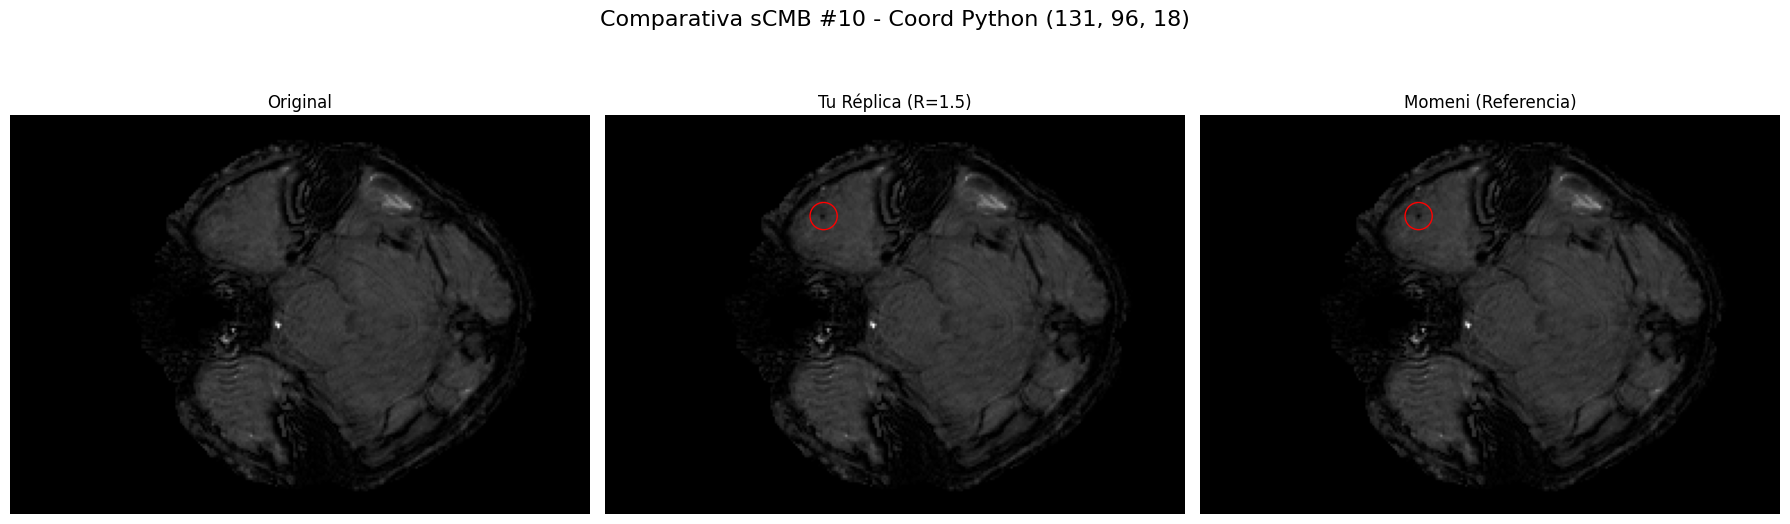

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib

# ==========================================
# 1. RUTAS
# ==========================================
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021"
PATH_ORIGINAL = os.path.join(BASE_DIR, "NoCMB", "101_T1_MRI_SWI_BFC_50mm_HM.nii.gz")
PATH_MOMENI = os.path.join(BASE_DIR, "NoCMB_sCMB", "101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1.nii.gz")
PATH_REPLICA = os.path.join(BASE_DIR, "sCMBS_Replica_Momeni", "101_Replica_Momeni_Math_V1.nii.gz")

# Coordenadas ORIGINALES (Base 1)
RAW_COORDINATES = [
    (93, 167, 22), (30, 164, 45), (56, 187, 33), (46, 71, 39), (49, 184, 36),
    (52, 109, 16), (84, 161, 28), (96, 184, 65), (27, 154, 43), (132, 97, 19)
]

# --- CORRECCIÓN PARA VISUALIZAR (Base 0) ---
COORDINATES_LIST = [(x-1, y-1, z-1) for (x, y, z) in RAW_COORDINATES]

# ==========================================
# 2. VISUALIZACIÓN
# ==========================================
print("Cargando volúmenes...")
if os.path.exists(PATH_REPLICA):
    img_orig = nib.load(PATH_ORIGINAL).get_fdata()
    img_momeni = nib.load(PATH_MOMENI).get_fdata()
    img_replica = nib.load(PATH_REPLICA).get_fdata()

    print("Generando comparativas...")
    
    for i, coord in enumerate(COORDINATES_LIST):
        cx, cy, cz = coord
        
        # Ajustamos el círculo rojo al radio visualizado (aprox)
        # Como hemos inyectado R=1.5, un círculo de R=5 debería rodearla bien sin taparla
        VIS_CIRCLE_RADIUS = 6 
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"Comparativa sCMB #{i+1} - Coord Python {coord}", fontsize=16)
        
        # Coordenadas Matplotlib (x=columna, y=fila) -> (cy, cx)
        plot_x = cy 
        plot_y = cx 
        
        # --- COL 1: ORIGINAL ---
        axes[0].imshow(img_orig[:, :, cz], cmap="gray", origin="lower")
        axes[0].set_title("Original")
        axes[0].axis("off")
        
        # --- COL 2: TU RÉPLICA (MINI) ---
        axes[1].imshow(img_replica[:, :, cz], cmap="gray", origin="lower")
        axes[1].set_title("Tu Réplica (R=1.5)")
        axes[1].axis("off")
        c1 = patches.Circle((plot_x, plot_y), radius=VIS_CIRCLE_RADIUS, edgecolor='red', facecolor='none', linewidth=1)
        axes[1].add_patch(c1)
        
        # --- COL 3: MOMENI (GROUND TRUTH) ---
        axes[2].imshow(img_momeni[:, :, cz], cmap="gray", origin="lower")
        axes[2].set_title("Momeni (Referencia)")
        axes[2].axis("off")
        c2 = patches.Circle((plot_x, plot_y), radius=VIS_CIRCLE_RADIUS, edgecolor='red', facecolor='none', linewidth=1)
        axes[2].add_patch(c2)
        
        plt.tight_layout()
        plt.show()

Para analizar la similitud, realizamos una comparativa de los perfiles de intensidad y hallamos la métrica de similitud. Esta comparativa se realiza en un cuadrado de 20x20 píxeles alrededor de la CMB.

Cargando volúmenes...
Volúmenes cargados.

--- INICIANDO ANÁLISIS COMPARATIVO (MÉTRICAS 3D) ---



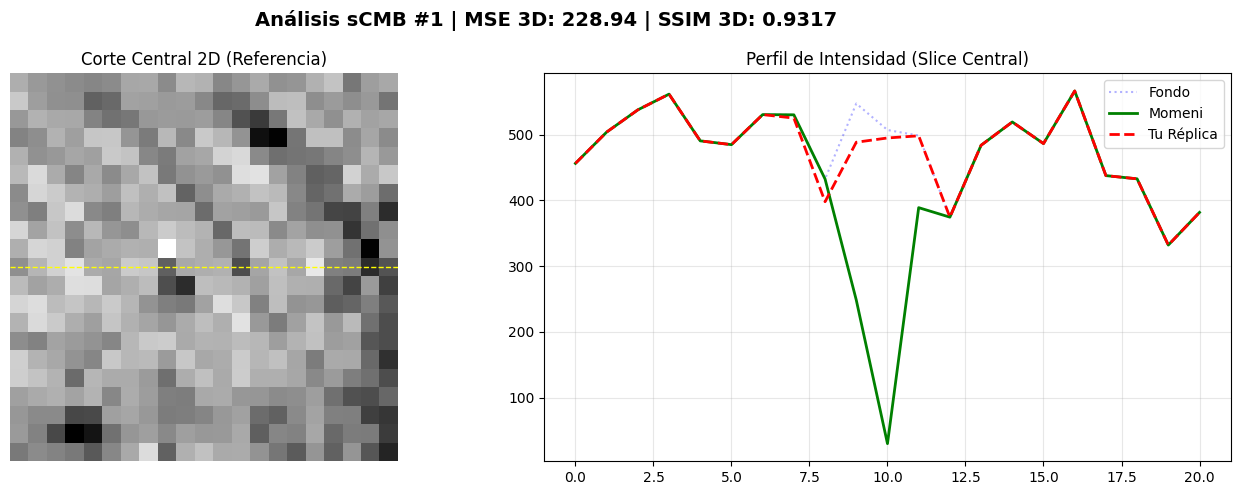

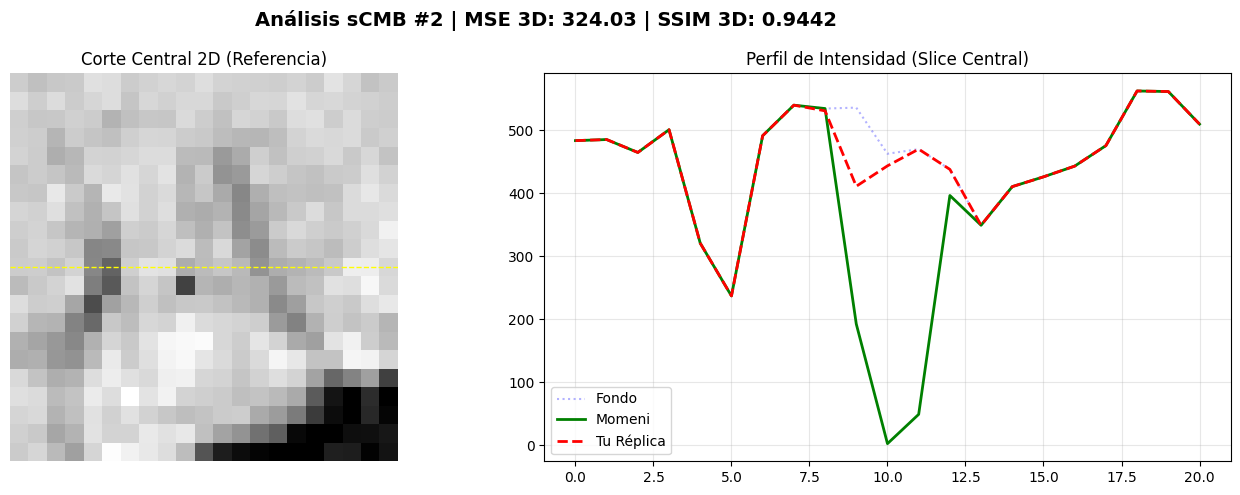

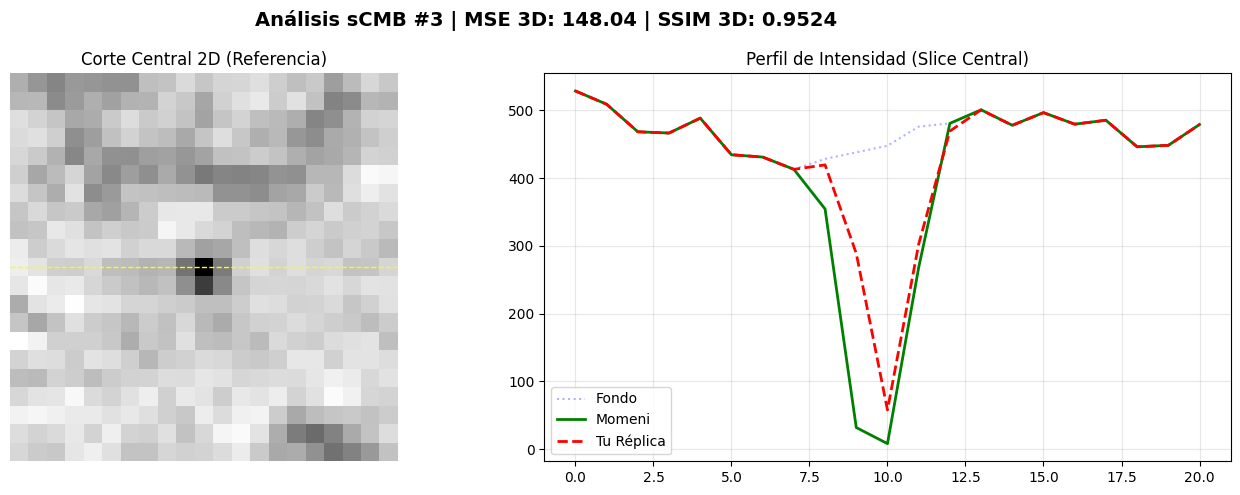

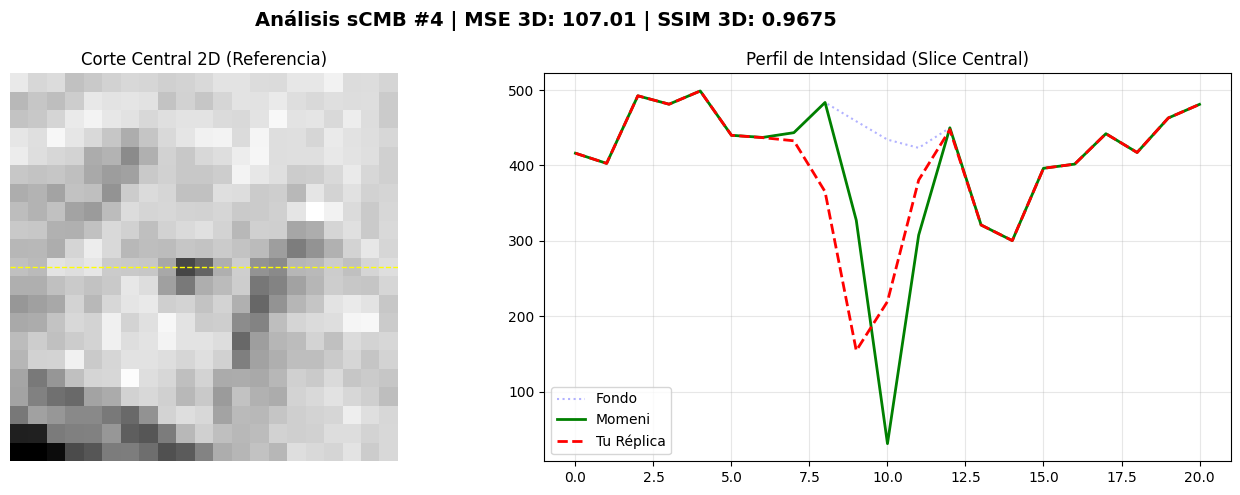

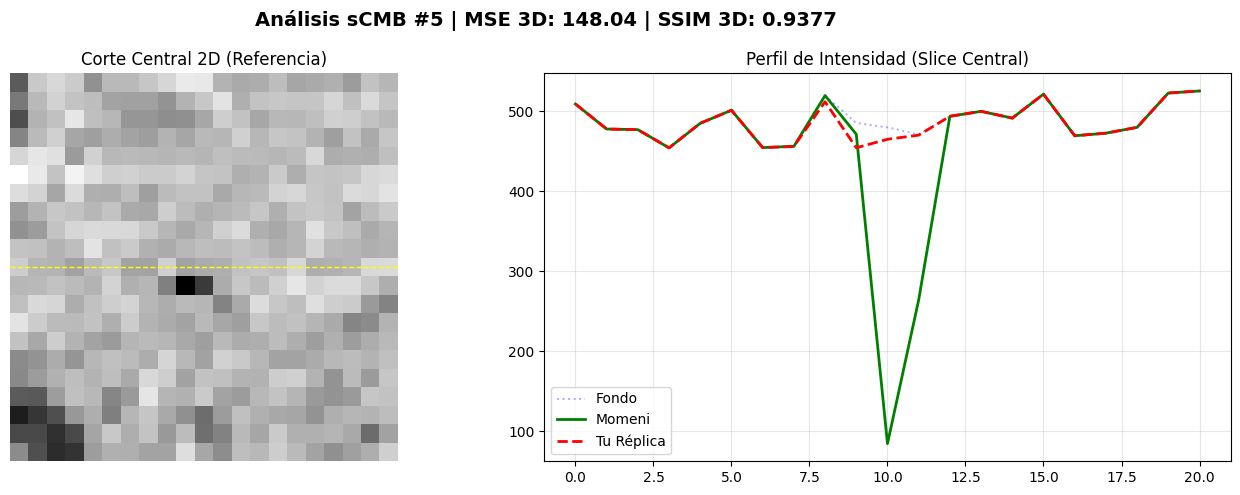

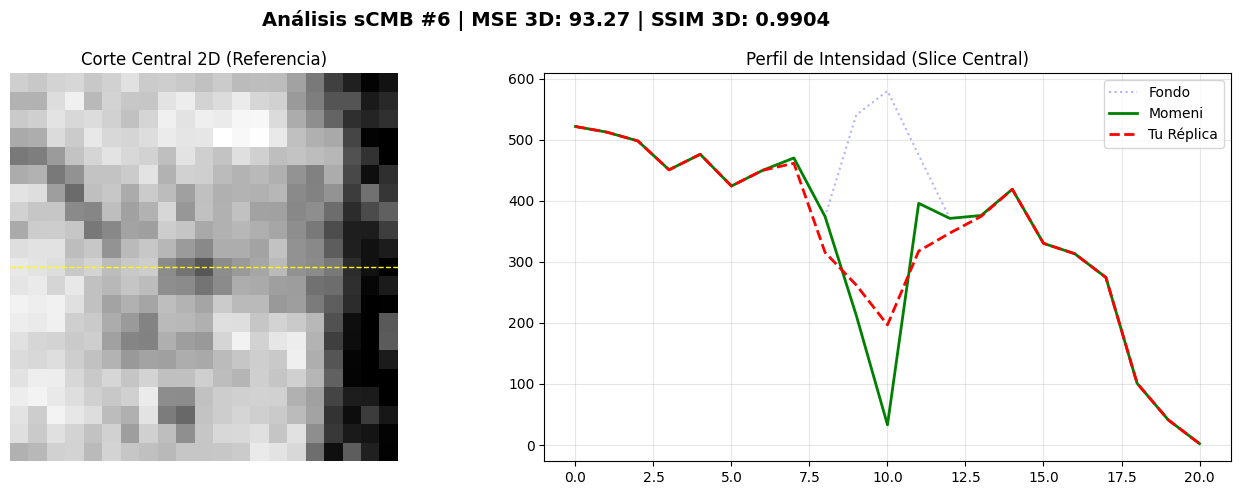

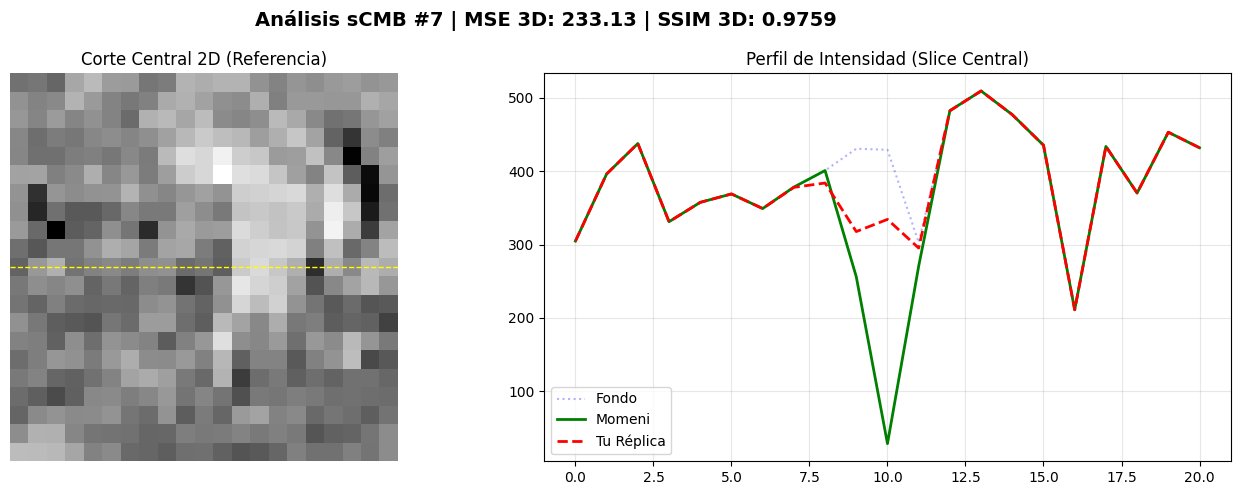

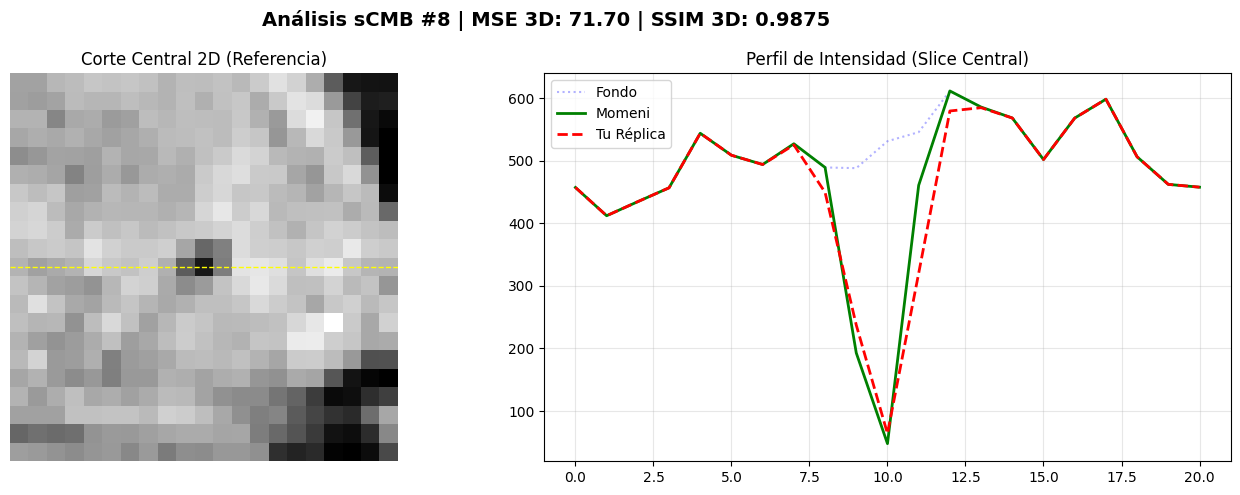

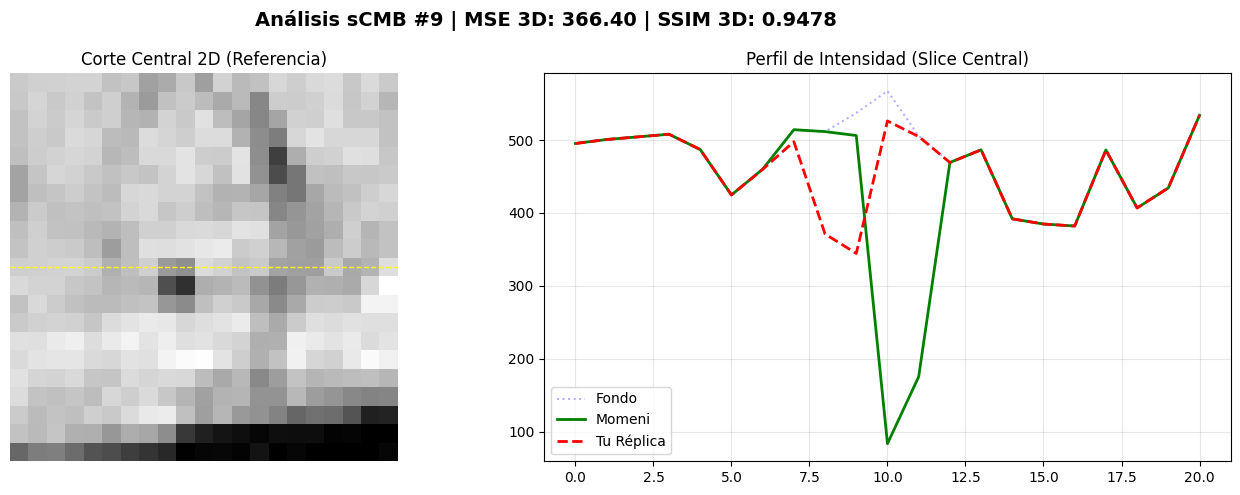

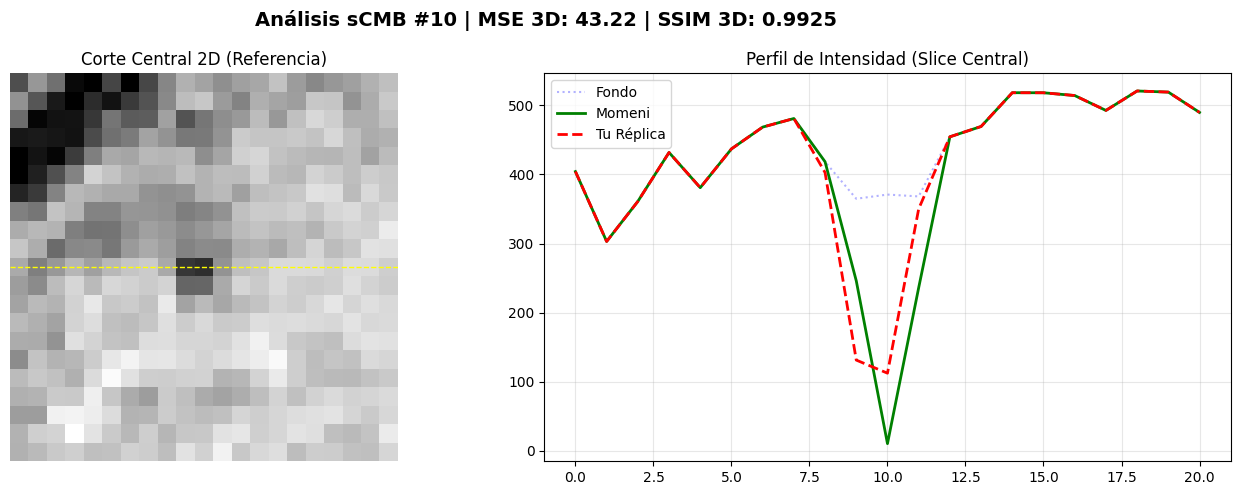

----------------------------------------
RESULTADOS GLOBALES (Promedio 10 lesiones en 3D):
MSE Promedio:  176.3769
SSIM Promedio: 0.9628
----------------------------------------


In [19]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021"
PATH_ORIGINAL = os.path.join(BASE_DIR, "NoCMB", "101_T1_MRI_SWI_BFC_50mm_HM.nii.gz")
PATH_MOMENI = os.path.join(BASE_DIR, "NoCMB_sCMB", "101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1.nii.gz")
PATH_REPLICA = os.path.join(BASE_DIR, "sCMBS_Replica_Momeni", "101_Replica_Momeni_Math_V1.nii.gz")

# Coordenadas Base 1 (Excel)
RAW_COORDINATES = [
    (93, 167, 22), (30, 164, 45), (56, 187, 33), (46, 71, 39), (49, 184, 36),
    (52, 109, 16), (84, 161, 28), (96, 184, 65), (27, 154, 43), (132, 97, 19)
]
COORDINATES_LIST = [(x-1, y-1, z-1) for (x, y, z) in RAW_COORDINATES]

# ==========================================
# 2. CARGA DE DATOS
# ==========================================
print("Cargando volúmenes...")
if not os.path.exists(PATH_REPLICA):
    print("ERROR: No se encuentra el archivo de tu réplica.")
else:
    img_orig = nib.load(PATH_ORIGINAL).get_fdata()
    img_momeni = nib.load(PATH_MOMENI).get_fdata()
    img_replica = nib.load(PATH_REPLICA).get_fdata()
    print("Volúmenes cargados.")

    all_mse = []
    all_ssim = []

    print("\n--- INICIANDO ANÁLISIS COMPARATIVO (MÉTRICAS 3D) ---\n")
    
    for i, coord in enumerate(COORDINATES_LIST):
        cx, cy, cz = coord
        
        # Tamaño de ventana (Radio del cubo)
        window = 10 
        
        # --- A) EXTRAER CUBOS 3D (Para las métricas) ---
        # Cogemos +/- 10 píxeles en X, Y y también en Z
        # Así capturamos la lesión entera aunque se haya movido verticalmente
        cube_momeni = img_momeni[cx-window:cx+window+1, cy-window:cy+window+1, cz-window:cz+window+1]
        cube_replica = img_replica[cx-window:cx+window+1, cy-window:cy+window+1, cz-window:cz+window+1]
        cube_orig = img_orig[cx-window:cx+window+1, cy-window:cy+window+1, cz-window:cz+window+1]
        
        # --- B) CÁLCULO DE MÉTRICAS 3D ---
        # Ahora comparamos VOLUMEN vs VOLUMEN.
        # Si la lesión de Momeni está en la slice 5 del cubo y la tuya en la 4,
        # el MSE 3D será mucho más justo que el 2D que fallaba si no coincidían.
        d_range = cube_momeni.max() - cube_momeni.min()
        
        val_mse = mean_squared_error(cube_momeni, cube_replica)
        val_ssim = ssim(cube_momeni, cube_replica, data_range=d_range, channel_axis=None) # channel_axis=None indica que es un volumen gris 3D
        
        all_mse.append(val_mse)
        all_ssim.append(val_ssim)
        
        # --- C) PREPARAR VISUALIZACIÓN 2D (Solo para el gráfico) ---
        # Para pintar, extraemos la slice central del cubo (índice 'window')
        mid_idx = window 
        slice_2d_momeni = cube_momeni[:, :, mid_idx]
        slice_2d_replica = cube_replica[:, :, mid_idx]
        slice_2d_orig = cube_orig[:, :, mid_idx]
        
        # Perfiles de intensidad (línea horizontal central de esa slice)
        profile_momeni = slice_2d_momeni[mid_idx, :]
        profile_replica = slice_2d_replica[mid_idx, :]
        profile_orig = slice_2d_orig[mid_idx, :]
        
        # ==========================================
        # 4. VISUALIZACIÓN GRÁFICA
        # ==========================================
        fig = plt.figure(figsize=(14, 5))
        # Nota: El título muestra las métricas calculadas en 3D
        fig.suptitle(f"Análisis sCMB #{i+1} | MSE 3D: {val_mse:.2f} | SSIM 3D: {val_ssim:.4f}", fontsize=14, fontweight='bold')
        
        # Panel 1: Visualización 2D (Solo referencia)
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(slice_2d_replica, cmap="gray", origin="lower")
        ax1.axhline(y=mid_idx, color='yellow', linestyle='--', linewidth=1)
        ax1.set_title("Corte Central 2D (Referencia)")
        ax1.axis("off")
        
        # Panel 2: Gráfica de Perfiles
        ax2 = fig.add_subplot(1, 2, 2)
        x_axis = np.arange(len(profile_orig))
        
        ax2.plot(x_axis, profile_orig, color='blue', alpha=0.3, label='Fondo', linestyle=':')
        ax2.plot(x_axis, profile_momeni, color='green', linewidth=2, label='Momeni')
        ax2.plot(x_axis, profile_replica, color='red', linewidth=2, linestyle='--', label='Tu Réplica')
        
        ax2.set_title("Perfil de Intensidad (Slice Central)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    # ==========================================
    # 5. RESUMEN FINAL
    # ==========================================
    print("-" * 40)
    print("RESULTADOS GLOBALES (Promedio 10 lesiones en 3D):")
    print(f"MSE Promedio:  {np.mean(all_mse):.4f}")
    print(f"SSIM Promedio: {np.mean(all_ssim):.4f}")
    print("-" * 40)

In [20]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.ndimage import binary_erosion, generate_binary_structure

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021"
DIR_INPUT = os.path.join(BASE_DIR, "NoCMB")
OUTPUT_DIR = os.path.join(BASE_DIR, "Ground_Truth_Pilot") # Carpeta nueva para organización

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

FILE_NAME = "101_T1_MRI_SWI_BFC_50mm_HM.nii.gz"
IMG_PATH = os.path.join(DIR_INPUT, FILE_NAME)

# Parámetros
NUM_SAMPLES = 20        # Cuántas coordenadas queremos generar
LABEL_RADIUS = 2        # Radio de la esfera en la etiqueta (en píxeles) para que se vea bien
SAFETY_MARGIN = 6       # Cuántos píxeles nos alejamos del borde del cráneo

# ==========================================
# 2. FUNCIONES AUXILIARES
# ==========================================

def get_safe_brain_mask(img_data, threshold=15, erosion_iters=5):
    """
    Crea una máscara binaria de las zonas seguras (lejos del borde).
    """
    # 1. Binarizar: Todo lo que brille más que 'threshold' es tejido
    binary = img_data > threshold
    
    # 2. Estructura para erosión 3D
    struct = generate_binary_structure(3, 1) # Conectividad 3D
    
    # 3. Erosión: 'Comemos' los bordes hacia adentro
    eroded = binary_erosion(binary, structure=struct, iterations=erosion_iters)
    
    return eroded

def create_spherical_label(shape, center, radius):
    """
    Crea una pequeña esfera de unos (1) en una matriz de ceros.
    """
    z, y, x = shape
    cz, cy, cx = center
    
    # Grid local alrededor del centro para no calcular toda la matriz (optimización)
    r = int(radius) + 1
    
    # Slice limits
    z_s, z_e = max(0, cz-r), min(z, cz+r+1)
    y_s, y_e = max(0, cy-r), min(y, cy+r+1)
    x_s, x_e = max(0, cx-r), min(x, cx+r+1)
    
    # Crear grid local
    zz, yy, xx = np.ogrid[z_s:z_e, y_s:y_e, x_s:x_e]
    
    # Ecuación de la esfera: (x-cx)^2 + ... <= r^2
    mask = (zz - cz)**2 + (yy - cy)**2 + (xx - cx)**2 <= radius**2
    
    return mask, (slice(z_s, z_e), slice(y_s, y_e), slice(x_s, x_e))

# ==========================================
# 3. PROCESO PRINCIPAL
# ==========================================
print(f"Cargando sujeto: {FILE_NAME}")
nii = nib.load(IMG_PATH)
data = nii.get_fdata()
affine = nii.affine

# 1. Generar Máscara de Seguridad
print("Calculando zona segura cerebral...")
safe_mask = get_safe_brain_mask(data, threshold=20, erosion_iters=SAFETY_MARGIN)
valid_coords = np.argwhere(safe_mask) # Lista de todas las coordenadas posibles [x, y, z]

print(f"   -> Vóxeles seguros disponibles: {len(valid_coords)}")

# 2. Elegir Coordenadas al Azar
print(f"Seleccionando {NUM_SAMPLES} coordenadas aleatorias...")
# Fijamos semilla para que siempre salgan las mismas en este piloto (puedes quitarlo luego)
np.random.seed(42) 

random_indices = np.random.choice(len(valid_coords), size=NUM_SAMPLES, replace=False)
selected_coords = valid_coords[random_indices]

# 3. Crear el Volumen de Etiquetas (Label Map)
print("Pintando archivo de etiquetas (Ground Truth)...")
label_vol = np.zeros(data.shape, dtype=np.uint8) # Todo negro

coord_list_metadata = []

for i, coord in enumerate(selected_coords):
    # coord viene como [x, y, z] de numpy
    cx, cy, cz = coord
    
    # Pintar esfera en el label
    sphere_mask, slices = create_spherical_label(data.shape, coord, radius=LABEL_RADIUS)
    
    # Sumar a la etiqueta (usamos lógica OR para no sumar valores si se solapan)
    label_vol[slices][sphere_mask] = 1
    
    # Guardar metadata para CSV
    coord_list_metadata.append({
        "id": i+1,
        "x": cx, "y": cy, "z": cz,
        "region": "brain_safe"
    })

# ==========================================
# 4. GUARDADO
# ==========================================
# A) Guardar NIfTI de Labels
out_label_name = FILE_NAME.replace(".nii.gz", "_SEG.nii.gz") # Convención _SEG para segmentación
out_label_path = os.path.join(OUTPUT_DIR, out_label_name)

nib.save(nib.Nifti1Image(label_vol, affine, nii.header), out_label_path)

# B) Guardar CSV con coordenadas
out_csv_path = os.path.join(OUTPUT_DIR, "coords_pilot_101.csv")
df = pd.DataFrame(coord_list_metadata)
df.to_csv(out_csv_path, index=False)

print("-" * 50)
print("¡PROCESO TERMINADO!")
print(f"Carpeta: {OUTPUT_DIR}")
print(f"1️-Label File (Máscara): {out_label_name}")
print(f"2️-Coordenadas (CSV):    coords_pilot_101.csv")
print("-" * 50)
print("IMPORTANTE: Abre la imagen original y el archivo _SEG en ITK-SNAP.")
print("Deberías ver puntos rojos dispersos SOLO en tejido cerebral, nunca fuera.")

Cargando sujeto: 101_T1_MRI_SWI_BFC_50mm_HM.nii.gz
Calculando zona segura cerebral...
   -> Vóxeles seguros disponibles: 661527
Seleccionando 20 coordenadas aleatorias...
Pintando archivo de etiquetas (Ground Truth)...
--------------------------------------------------
¡PROCESO TERMINADO!
Carpeta: /media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021/Ground_Truth_Pilot
1️-Label File (Máscara): 101_T1_MRI_SWI_BFC_50mm_HM_SEG.nii.gz
2️-Coordenadas (CSV):    coords_pilot_101.csv
--------------------------------------------------
IMPORTANTE: Abre la imagen original y el archivo _SEG en ITK-SNAP.
Deberías ver puntos rojos dispersos SOLO en tejido cerebral, nunca fuera.
